## In this notebook: Figures 4B, 4D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import mne

from statannotations.Annotator import Annotator
import itertools

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats

import matplotlib as mpl
plt.style.use("article.mplstyle")
sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

In [3]:

erp_times = create_erp_times(-0.5,0.5, 128)
ep_path = '../analysis_error/error_epochs_data_n05to05_30Hz_corrected'
mapchange_path = '../analysis_error/mapchange_csv_corrected_since_bymap_till'


good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
print(subjects_to_process)

#time points to consider
time_to_plot = [0.08, 0.12] #N100
# time_to_plot = [0, 0.5]  #peak to peak P50 to N100
# time_to_plot = [0.025, 0.06] #P50
#time_to_plot = [0.1]

#find either max, min, or peak to peak
peak = np.min #np

time_idx = time_index_custom(time_to_plot, erp_times)

ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']

['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


### Prev keystroke differences

In [4]:
#ch_to_plot = ['FCz']
ch_idx = ch_index(ch_to_plot)


periods = ['pre', 'post']

data_f = []
data_o = []

col = 'orange'
for k, sub in enumerate(subjects_to_process):
    for period in periods:

        # Read epochs data
        ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
        eps = mne.read_epochs(ep_file).get_data()

        # Read mapchange data
        mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
        mapchange_df = pd.read_csv(mapchange_file)
        mapchange_df_firsts = mapchange_df.query('type =="first"')
        mapchange_df_others = mapchange_df.query('type =="other"')


        #add to dataframe for the first keystrokes
        for i, row in mapchange_df_firsts.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                prev_keystrokes = row['prev_keystrokes']
                map_type = row['map']
                prevmap_type = row['prev_map']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx]) #include multiple channels and single timepoint
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]]) #include multiple timepoint and single channel
                amp = peak(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1)) #include multiple time points and multiple channels
                data_f.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'first',
                    'prev_keystrokes': prev_keystrokes,
                    'amp_f': amp, 
                    'map_type': map_type,
                    'prevmap_type': prevmap_type
                })
                
                

            except IndexError: 
                print(f'Index error in first keystrokes for {sub}')
                continue
            
        for i, row in mapchange_df_others.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                map_type = row['map']
                prevmap_type = row['prev_map']
                amp = peak(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1))
                data_o.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'other',
                    'prev_keystrokes': -1,
                    'amp_o': amp,
                    'map_type': map_type,
                    'prevmap_type': prevmap_type
                    })
                
            
            except IndexError:
                print(f'Index error in other keystrokes for {sub} {period}')
                continue 

f_df = pd.DataFrame(data_f)
o_df = pd.DataFrame(data_o)

Index error in other keystrokes for 04 post
Index error in other keystrokes for 17 post


In [5]:
# get average erp for others 
periods =['pre', 'post']
data_o_ave = []
for sub in subjects_to_process:
    for period in periods:
        o_df_sub = o_df.query(f'subject == "{sub}" and period == "{period}"')
        aveamp = o_df_sub['amp_o'].mean()
    
        data_o_ave.append(
            {'subject': sub,
            'period': period,
            'aveamp_o': aveamp}
        )

data_o_ave = pd.DataFrame(data_o_ave)

In [6]:
#subtract average of all others from each first ERP 
df_diff = pd.merge(f_df, data_o_ave, on=['subject', 'period'])
df_diff['diff'] = df_diff['amp_f']-df_diff['aveamp_o']

## Figure 4B

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Custom statistical test, P_val:6.063e-01
0.0 vs. 2.0: Custom statistical test, P_val:2.191e-01
0.0 vs. 3.0: Custom statistical test, P_val:2.715e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 0.0: Custom statistical test, P_val:5.255e-03
1.0 vs. 1.0: Custom statistical test, P_val:1.707e-04
2.0 vs. 2.0: Custom statistical test, P_val:6.295e-04
3.0 vs. 3.0: Custom statistical test, P_val:9.087e-07


/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_43840/4231208497.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(data=df_filtered, x='prev_keystrokes', y='diff', estimator=np.mean, ci=95)
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstanc

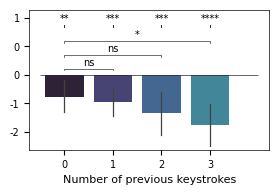

In [15]:



sns.set_palette("mako") 


# Get the first 4 unique values of 'prev_keystrokes'
first_4 = [0, 1, 2, 3]
df_filtered = df_diff[df_diff['prev_keystrokes'].isin(first_4)]


fig = plt.figure(figsize=(2.4,1.4))
ax = fig.add_axes([0,0,1,1])
ax = sns.barplot(data=df_filtered, x='prev_keystrokes', y='diff', estimator=np.mean, ci=95)


# annotate pairwise diffs
# Define pairwise comparisons
pairs = [(0, 1), (0, 2), (0, 3)]
#pairwise stats
p_values_dict = {pair: stats.ttest_ind(df_filtered[df_filtered['prev_keystrokes'] == pair[0]]['diff'],
                                  df_filtered[df_filtered['prev_keystrokes'] == pair[1]]['diff']).pvalue 
            for pair in pairs}

annotator = Annotator(ax, pairs, data=df_filtered, x='prev_keystrokes', y='diff')
p_values = list(p_values_dict.values())
annotator.set_pvalues(p_values)
annotator.configure(fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'])
annotator.annotate()

#annotate diff from 0
# Define pairs for each level of 'prev_keystrokes' against 0
pairs = [(n_keystroke, n_keystroke) for n_keystroke in first_4]

# Initialize Annotator with the pairs
annotator_1samp = Annotator(ax, pairs, data=df_filtered, x='prev_keystrokes', y='diff')
#annotator_1samp.configure(loc ='outside')

p_values_1samp = []
for n_keystroke in first_4:
    group_data = df_filtered[df_filtered['prev_keystrokes'] == n_keystroke]['diff']
    t_stat, p_val = stats.ttest_1samp(group_data, 0)
    p_values_1samp.append(p_val)
annotator_1samp.set_pvalues(p_values_1samp)
annotator_1samp.configure(fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'])
annotator_1samp.annotate(line_offset_to_group=0.4)


plt.hlines(0,-0.5,4)
# plt.ylabel('Δ amplitude vs others (µV)')
plt.ylabel('')
plt.xlabel('Number of previous keystrokes')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer


# plt.title(f'Difference amplitude - ave amplitude of others {time_to_plot}')
plt.xticks([0, 1, 2, 3], labels = [int(x) for x in [0, 1, 2, 3]]) 
# plt.yticks(fontsize = 15)

plt.savefig('./figures/surprisal_firsts.svg', transparent=True)

##### Stats on prev keystroke differences

In [8]:
#multiple comparisons
ps = []
firsts_0 = df_diff[df_diff['prev_keystrokes']==0]['diff'].values

for i in range(1, 4):
    firsts_i = df_diff[df_diff['prev_keystrokes']==i]['diff'].values
    _, p = stats.ttest_ind(firsts_0, firsts_i)
    ps.append(p)


ps_corr = fdrcorrection(ps)
print('uncorrected p', ps)
print('corrected p', ps_corr)

uncorrected p [0.6062890815736343, 0.21911010763816252, 0.02715236737554926]
corrected p (array([False, False, False]), array([0.60628908, 0.32866516, 0.0814571 ]))


### Keystrokes since mapchange all maps

In [9]:

ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']
#ch_to_plot = ['FCz']
ch_idx = ch_index(ch_to_plot)


periods = ['pre' ,'post']

data_o = []

for k, sub in enumerate(subjects_to_process):
    for period in periods:

        # Read epochs data
        ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
        eps = mne.read_epochs(ep_file).get_data()

        # Read mapchange data
        mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
        mapchange_df = pd.read_csv(mapchange_file)
        mapchange_df_others = mapchange_df.query('type == "other"')

        for i, row in mapchange_df_others.iterrows():
           
            
            try:
                keystroke_idx = row['keystroke_idx']
                keystrokes_since = row['keystrokes_since']
                map_type = row['map']
                prevmap_type = row['prev_map']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]])


                amp = peak(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1))
                data_o.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'other',
                    'keystrokes_since': keystrokes_since,
                    'amp_o': amp,
                    'map_type':map_type,
                    'prevmap_type': prevmap_type
                    })
                
            
            except IndexError:
                print(f'Index error in other keystrokes for {sub} {period}, double check') #subs 04 and 17 post may have index error because the recordings are slightly shorter
                continue 

o_df_since = pd.DataFrame(data_o)

Index error in other keystrokes for 04 post, double check
Index error in other keystrokes for 17 post, double check


## Figure 4D: First vs others by map ENTERED

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_43840/1342026765.py:36: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Amplitude ($\mu$V)')
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Cat

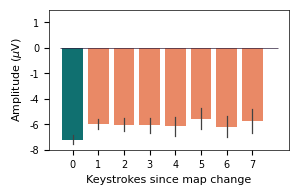

In [12]:
#combine first and others data to plot together

f_df['keystrokes_since'] = -1 

of_df = pd.concat([
    f_df.assign(amp=f_df['amp_f']),
    o_df_since.assign(amp=o_df_since['amp_o'])
])

of_df['keystrokes_since'] += 1 #set the keystrokes since to 0 for first keystrokes and >0 for others


######
period = 'pre'
maps = 'all'
max_keystrokes = 8

of_df_filt = of_df[of_df['keystrokes_since'] < max_keystrokes]

if maps != 'all':  # Apply map filtering only if maps is not 'all'
    of_df_filt = of_df_filt.query(f'map_type == "{maps}"')

fig = plt.figure(figsize = (2.4,1.4))
ax = fig.add_axes([0,0,1,1])

num_bars = len(of_df_filt)
colors = sns.light_palette("coral", n_colors=num_bars)[::-1]  
colors[0] = 'teal'

if period == 'all':
    ax = sns.barplot(of_df_filt, x = 'keystrokes_since', y = 'amp', palette = colors)
else:
    ax = sns.barplot(of_df_filt.query(f'period == "{period}"'), x = 'keystrokes_since', y = 'amp', palette = colors)


plt.ylabel('Amplitude ($\mu$V)')
plt.xlabel('Keystrokes since map change')
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))  
plt.ylim(-8e-6, 3e-6)
plt.hlines(0,-0.5,8)


# automatic annotations (I will draw them by hand because I don't want brackets on all of the bars)

pairs = [
   # (-1,1), (-1,2), (-1,4), (-1,6), (-1,9), (-1,12), (-1, 16)
    (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7)
]
p_values_dict = {pair: stats.ttest_ind(of_df_filt[of_df_filt['keystrokes_since'] == pair[0]]['amp'],
                                  of_df_filt[of_df_filt['keystrokes_since'] == pair[1]]['amp']).pvalue 
            for pair in pairs}



annotator_o = Annotator(ax, pairs, data=of_df_filt, x='keystrokes_since', y='amp')
p_values = list(p_values_dict.values())
annotator_o.set_pvalues(p_values)
# annotator_o.annotate(line_offset_to_group=0.4)
p_values

plt.savefig('./figures/surprisal_others.svg', transparent = True)

# plt.title(f'{period} training, {maps} map, {time_to_plot}')

In [11]:
print(p_values)

[1.6124179936540808e-08, 6.366913392402199e-06, 1.6618232499305428e-06, 0.0018144184816935856, 8.856874266772437e-05, 0.002036261710487477, 0.001975794540558705]
